# KNN classifier

In [30]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [31]:
df = pd.read_csv('dataset.csv')
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
validation_df = pd.read_csv('validation.csv')

## Split the features and the target column and normalize the data

In [32]:
scaler = MinMaxScaler()

# full dataset
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class']

# splits
X_train = scaler.fit_transform(train_df.drop('Class', axis=1))
y_train = train_df['Class']
X_validation = scaler.fit_transform(validation_df.drop('Class', axis=1))
y_validation = validation_df['Class']
X_test = scaler.fit_transform(test_df.drop('Class', axis=1))
y_test = test_df['Class']

## Train the model

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


def get_result_stats(clf, X, y) -> None:
    y_pred = clf.predict(X)
    y_prob = clf.predict_proba(X)

    conf_matrix = confusion_matrix(y, y_pred, labels=["Kecimen", "Besni"])
    print("Confusion Matrix:\n", conf_matrix)

    acc = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_prob)
    print(f"Accuracy: {acc:.3f}, AUC: {auc_score:.3f}")

    precision = precision_score(y, y_pred, pos_label="Kecimen")
    print(f"Precision: {precision:.3f}")

    recall = recall_score(y, y_pred, pos_label="Kecimen")
    print(f"Recall: {recall:.3f}")

    f1 = f1_score(y, y_pred, pos_label="Kecimen")
    print(f"F1 Score: {f1:.3f}")

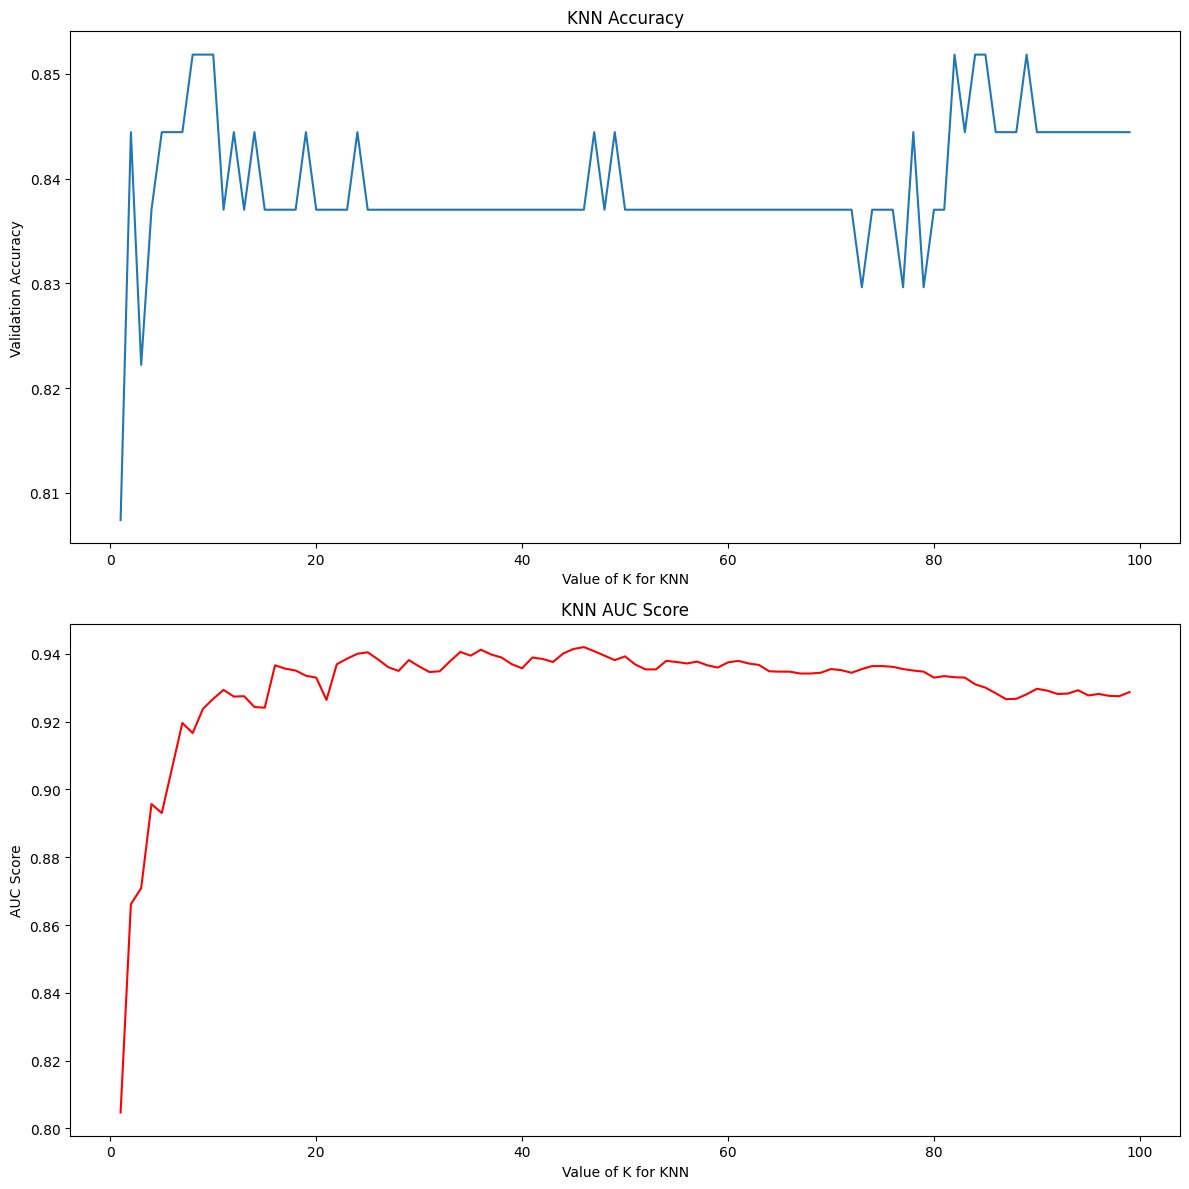

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 100)
validation_scores = []
auc_scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_validation)
    y_pred_prob = knn.predict_proba(X_validation)[:, 1]

    accuracy = accuracy_score(y_validation, y_pred)
    auc = roc_auc_score(y_validation, y_pred_prob)

    validation_scores.append(accuracy)
    auc_scores.append(auc)

plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(k_values, validation_scores, label='Accuracy')
plt.xlabel('Value of K for KNN')
plt.ylabel('Validation Accuracy')
plt.title('KNN Accuracy')

plt.subplot(2, 1, 2)
plt.plot(k_values, auc_scores, label='AUC', color='red')
plt.xlabel('Value of K for KNN')
plt.ylabel('AUC Score')
plt.title('KNN AUC Score')

plt.tight_layout()
plt.show()

In [35]:
import umap

reducer = umap.UMAP()
X_train_umap = reducer.fit_transform(X_train)
X_test_umap = reducer.transform(X_test)

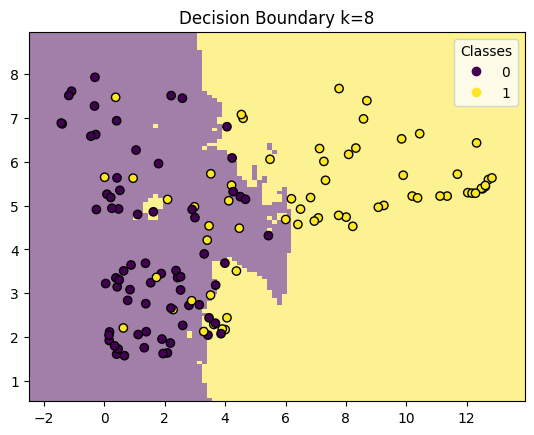

In [36]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier

label_mapping = {'Kecimen': 0, 'Besni': 1}
y_train_numeric = y_train.map(label_mapping)
y_test_numeric = y_test.map(label_mapping)

clf = KNeighborsClassifier(n_neighbors=8, weights="uniform")
clf.fit(X_train_umap, y_train_numeric)

disp = DecisionBoundaryDisplay.from_estimator(
    clf,
    X_test_umap,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_test_umap[:, 0], X_test_umap[:, 1], c=y_test_numeric, edgecolors="k")
disp.ax_.legend(*scatter.legend_elements(), title="Classes")
disp.ax_.set_title(f"Decision Boundary k={8}")

plt.show()
